In [1]:
#### DO NOT RUN THIS CODE IN THE NOTEBOOK - copy paste into terminal in the HOME directory!

# git clone https://github.com/tensorflow/models.git

In [2]:
 # !pip install s3fs -q
 # !pip install tensorflow_hub -q
 # !pip install tensorflow_datasets -q
 # !pip install pycocotools -q
 # !pip install gin-config -q
 # !pip install immutabledict -q
 # !pip install sentencepiece -q
 # !pip install transformers -q
 # !pip install -r official/projects/movinet/requirements.txt -q

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import configparser

config = configparser.ConfigParser()
config.read('/home/ec2-user/.aws/credentials')

['/home/ec2-user/.aws/credentials']

In [3]:
# AWS credentials and S3 settings
aws_access_key_id = config["default"]['aws_access_key_id']
aws_secret_access_key = config["default"]['aws_secret_access_key']
bucket_name = 'asl-capstone'
s3_URI = 's3://asl-capstone/'

In [4]:
import s3fs
fs = s3fs.S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)

import boto3
s3 = boto3.client('s3',aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key,
                  region_name = 'us-west-2')


In [5]:
import tensorflow as tf, tf_keras
import tensorflow_hub as hub
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import requests
from typing import List, Tuple
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

tf.keras.backend.clear_session()

2023-11-22 02:23:29.888319: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 02:23:30.595421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
%cd /home/ec2-user/models

/home/ec2-user/models


In [7]:
pwd

'/home/ec2-user/models'

In [8]:
# # !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz
# !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a3_base.tar.gz
# # !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a5_base.tar.gz
# # !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a5_base_k400.tar.gz

# # !tar -xf movinet_a5_base_k400.tar.gz
# # !mv movinet_a5_base movinet_a5_base_k400
# # !tar -xf movinet_a0_base.tar.gz
# !tar -xf movinet_a3_base.tar.gz
# # !tar -xf movinet_a5_base.tar.gz

In [11]:
model_version = 'a3'

if model_version=='a3':
  max_frames = 120
  image_dims = (256,256)
elif model_version=='a0':
  max_frames = 50
  image_dims = (172,172)
elif model_version=='a5':
  max_frames = 120
  image_dims = (320,302)

In [12]:
# Get the kinetics-600 action labels
KINETICS_URL = "official/projects/movinet/files/kinetics_600_labels.txt"
with open(KINETICS_URL) as obj:
  labels_600 = [line for line in obj.readlines()]
print("Found %d labels." % len(labels_600))

Found 600 labels.


In [9]:
video_files = pd.read_parquet('s3://asl-capstone/wlasl/video_mappings_masterfile.parquet')

In [10]:
display(video_files.head())
print(video_files.shape)
print(video_files.word.nunique())

,rgb_path,padded_path,word,frame_count,label_num
0,asl-capstone/wlasl/RGB/viewpoint_0.npy,asl-capstone/wlasl/padded/viewpoint_0.npy,viewpoint,93,1892
1,asl-capstone/wlasl/RGB/viewpoint_1.npy,asl-capstone/wlasl/padded/viewpoint_1.npy,viewpoint,82,1892
2,asl-capstone/wlasl/RGB/viewpoint_2.npy,asl-capstone/wlasl/padded/viewpoint_2.npy,viewpoint,40,1892
3,asl-capstone/wlasl/RGB/viewpoint_3.npy,asl-capstone/wlasl/padded/viewpoint_3.npy,viewpoint,81,1892
4,asl-capstone/wlasl/RGB/viewpoint_4.npy,asl-capstone/wlasl/padded/viewpoint_4.npy,viewpoint,111,1892


(11938, 5)
1995


In [11]:
words = video_files.word.value_counts()[video_files.word.value_counts() >= 11].reset_index()['word'].unique()

video_files = video_files[video_files.word.isin(words)]
video_files.shape

(680, 5)

In [12]:
NUM_CLASSES = video_files.word.nunique()
NUM_CLASSES

56

In [13]:
print(video_files['frame_count'].mean())
print(video_files['frame_count'].median())
print(video_files['frame_count'].max())

64.08088235294117
62.5
195


In [14]:
train_files, test_files = train_test_split(video_files, train_size=0.8)
print(train_files.shape)
print(test_files.shape)

(544, 5)
(136, 5)


In [15]:
train_files['flip'] = False

bootstrap = train_files.groupby('word').sample(5)
bootstrap['flip'] = True

train_files = pd.concat([train_files, bootstrap]).sample(frac=1)
train_files.shape

(824, 6)

In [20]:
def data_generator(file_paths_df, add_flip=False):
    for _, row in file_paths_df.iterrows():
        with fs.open(row['padded_path'], 'rb') as f:
            video = np.load(f)

        if add_flip:
            if row['flip']==True:
                video = np.flip(video, axis=2)
            
        #video = pad_video_frames(video, n_frames=n_frames)
        label = tf.one_hot(row['label_num'], NUM_CLASSES)
        yield video, label


# Create TensorFlow Dataset for model input. 
train_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(train_files, add_flip=True),
    output_signature=(
        tf.TensorSpec(shape=(120, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(NUM_CLASSES), dtype=tf.int32)
    )
)

# Create TensorFlow Dataset for model input. 
test_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(test_files),
    output_signature=(
        tf.TensorSpec(shape=(120, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(NUM_CLASSES), dtype=tf.int32)
    )
)

2023-11-21 23:21:22.728266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 23:21:22.748976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 23:21:22.749830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [21]:
#next(iter(train_dataset.batch(1))) #Does a sanity check to confirm that the dataset is processed in batches

In [22]:
#from official.projects.movinet.modeling import movinet_model

from official.projects.movinet.modeling import movinet

# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_version, #change to correspond to model
    causal=False,
    use_external_states=False,
)

In [23]:
# backbone.trainable = True

# for layer in backbone.layers[-3:-1]:
#     layer.trainable = True

In [24]:
from official.projects.movinet.modeling import movinet_model

def build_classifier(backbone, num_classes, freeze_backbone=False):
    """Builds a classifier on top of a backbone model."""
    model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
    model.build([2, 120, 256, 256, 3])

    model.layers[0].trainable = False
    model.layers[1].trainable = True
    model.layers[-1].trainable = True
    
    for i in range(25):
        model.layers[1].layers[i].trainable = False
    
    return model

# Wrap the backbone with a new classifier to create a new classifier head
# with num_classes outputs (101 classes for UCF101).
# Freeze all layers except for the final classifier head.
model = build_classifier(backbone, NUM_CLASSES)

In [25]:
model.summary()

Model: "movinet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    4688129   
                             None, None, 16),                    
                              'block0_layer0': (None             
                             , None, None, None, 16)             
                             , 'block0_layer1': (Non             
                             e, None, None, None, 16             
                             ),                                  
                              'block0_layer2': (None             
                             , None, None, None, 16)             
                             , 'block0_layer3': 

In [26]:
# import tensorflow_model_optimization as tfmot

# # q_aware stands for for quantization aware.
# q_aware_model = tfmot.quantization.keras.quantize_apply(model)


# Dense layers should be quantized.
# def apply_quantization_to_dense(layer):
#   if isinstance(layer, tf.keras.layers.Dense):
#     return tfmot.quantization.keras.quantize_annotate_layer(layer)
#   return layer

# # Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# # to the layers of the model.
# annotated_model = tf.keras.models.clone_model(
#     base_model,
#     clone_function=apply_quantization_to_dense,
# )

# # Now that the Dense layers are annotated,
# # `quantize_apply` actually makes the model quantization aware.
# quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

# quant_aware_model.summary()

In [19]:
NUM_EPOCHS = 5
BATCH_SIZE = 8

train_steps = len(train_files) // BATCH_SIZE
total_train_steps = train_steps * NUM_EPOCHS

test_steps = len(test_files) // BATCH_SIZE

loss_obj = tf_keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.05)

metrics = [
    tf_keras.metrics.TopKCategoricalAccuracy(
        k=1, name='top_1', dtype=tf.float32),
    tf_keras.metrics.TopKCategoricalAccuracy(
        k=5, name='top_5', dtype=tf.float32),
]

initial_learning_rate = 0.001
learning_rate = tf_keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps, warmup_target=0.01, warmup_steps=3
)
optimizer = tf_keras.optimizers.RMSprop(learning_rate=learning_rate, 
                                        rho=0.9, momentum=0.9, 
                                        epsilon=1.0, clipnorm=1.0)

# model.compile(loss={'classifier_head':loss_obj, 'classifier_head_1':None}, 
#               optimizer='RMSprop', 
#               metrics={'classifier_head':metrics, 'classifier_head_1':None})

# model.compile(loss={'prediction':loss_obj, 'vid_embedding':None}, 
#               optimizer='RMSprop', 
#               metrics={'prediction':metrics, 'vid_embedding':None})

model.compile(loss=loss_obj, 
              optimizer=optimizer, 
              metrics=metrics)


# look into quantization for tf

[0.1,
 0.09999907,
 0.09999628,
 0.099991634,
 0.099985115,
 0.09997674,
 0.09996652,
 0.09995443,
 0.09994047,
 0.09992467,
 0.099907,
 0.09988748,
 0.09986609,
 0.09984286,
 0.099817775,
 0.09979083,
 0.09976204,
 0.099731386,
 0.09969889,
 0.09966453]

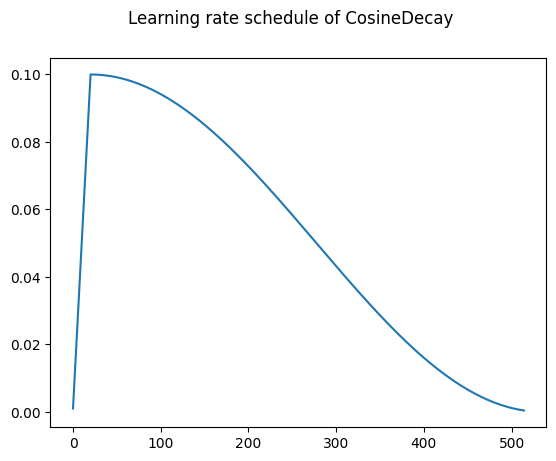

In [41]:
initial_learning_rate = 0.001
learning_rate = tf_keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps, warmup_target=0.05, warmup_steps=20
)

# initial_learning_rate = 0.001
# learning_rate = tf_keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps=total_train_steps, warmup_target=0.01, warmup_steps=3
# )

def visualize_lr_schedule(opt, n_steps, step_s) -> Tuple[List[int], List[float]]:
    """Visualize tensorflow keras scheduler learning rate over the course of n_steps training steps.

    Args:
        opt (LearningRateSchedule): learning rate scheduler to be visualized.
        n_steps (int): number of training steps to visualize over.
        step_s (int): sampling step of the training steps, i.e. takes each step_s in the interval [0, n_steps].

    Returns:
        Tuple[List[int], List[float]]: returns x (steps), y (lr values) values of the plot.
    """
    lr = []
    steps = list(range(0, n_steps, step_s))

    for step in steps:
        lr_at_s = opt(step).numpy()
        lr.append(lr_at_s)

    plt.suptitle(f'Learning rate schedule of {type(opt).__name__}')
    plt.plot(steps, lr)

    return steps, lr


steps, lr_values = visualize_lr_schedule(learning_rate, n_steps=total_train_steps, step_s=1)
lr_values[20:40]

In [ ]:
results = model.fit(
                train_dataset.batch(BATCH_SIZE), #14, lr = 0.001, RMSprop, bootstrapping, 56 classes
                validation_data=test_dataset.batch(BATCH_SIZE),
                epochs=NUM_EPOCHS,
                steps_per_epoch=train_steps,
                validation_steps=test_steps,
                verbose=1)

#14, lr = 0.001, RMSprop, bootstrapping, 56 classes
# 78/78 - 10124s 128s/step - loss: 0.8777 - classifier_head_loss: 0.8777 - classifier_head_top_1: 0.0147 - classifier_head_top_5: 0.2299 - val_loss: 0.1095 - val_classifier_head_loss: 0.1095 - val_classifier_head_top_1: 0.0238 - val_classifier_head_top_5: 0.0238

#14, lr = 0.0001, RMSprop, bootstrapping, 56 classes
# 10353s 132s/step - loss: 13.5087 - classifier_head_loss: 13.5087 - classifier_head_top_1: 0.0128 - classifier_head_top_5: 0.2930 - val_loss: 3.7397 - val_classifier_head_loss: 3.7397 - val_classifier_head_top_1: 0.0000e+00 - val_classifier_head_top_5: 0.0000e+00

2023-11-21 23:24:20.771113: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x203d5170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-21 23:24:20.771157: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-21 23:24:21.870041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-21 23:24:25.595043: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-21 23:25:05.372962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


83/96 [========================>.....] - ETA: 13:32 - loss: 0.2688 - top_1: 0.0166 - top_5: 0.1084

In [ ]:
def get_instance_id():
    """Get current instance ID from metadata"""
    url = "http://169.254.169.254/latest/meta-data/instance-id"
    response = requests.get(url)
    return response.text

def stop_instance(instance_id, region_name='us-west-2'):
    """Stop the EC2 instance"""
    ec2 = boto3.client('ec2', aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key, region_name=region_name)
    ec2.stop_instances(InstanceIds=[instance_id])

In [ ]:
# Get the current instance ID
instance_id = get_instance_id()
print(instance_id)
# Stop the instance
stop_instance(instance_id)

In [ ]:
results = model.fit(
                train_dataset.batch(BATCH_SIZE), #14, lr = 0.001, Adafactor, 656 classes
                validation_data=test_dataset.batch(BATCH_SIZE),
                epochs=NUM_EPOCHS,
                steps_per_epoch=train_steps,
                validation_steps=test_steps,
                verbose=1)

# 14/268 ETA: 7:43:44 - loss: 2.0779 - classifier_head_loss: 2.0779 - classifier_head_top_1: 0.0051 - classifier_head_top_5: 0.0204

 14/268 [>.............................] - ETA: 7:43:44 - loss: 2.0779 - classifier_head_loss: 2.0779 - classifier_head_top_1: 0.0051 - classifier_head_top_5: 0.0204

In [28]:
results = model.fit(
                train_dataset.batch(BATCH_SIZE), #12, lr = 0.01, adafactor, 656 classes
                validation_data=test_dataset.batch(BATCH_SIZE),
                epochs=NUM_EPOCHS,
                steps_per_epoch=train_steps,
                validation_steps=test_steps,
                verbose=1)

# 313/313 - ETA: 0s - loss: 5.5397 - classifier_head_loss: 5.5397 - classifier_head_top_1: 0.0013 - classifier_head_top_5: 0.0077 

2023-11-20 17:03:26.068579: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f8be1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-20 17:03:26.068629: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-20 17:03:29.061197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-20 17:03:36.363940: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-20 17:04:24.872884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-20 17:04:24.910181: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


313/313 [==============================] - ETA: 0s - loss: 5.5397 - classifier_head_loss: 5.5397 - classifier_head_top_1: 0.0013 - classifier_head_top_5: 0.0077  

KeyboardInterrupt: 

In [ ]:
# with tf.device("/GPU:0"):
results = model.fit(
                train_dataset.batch(BATCH_SIZE), #12, lr = 0.1, adafactor, 2000 classes
                validation_data=test_dataset.batch(BATCH_SIZE),
                epochs=NUM_EPOCHS,
                steps_per_epoch=train_steps,
                validation_steps=test_steps,
                verbose=1)
    
# results = q_aware_model.fit(
#                 train_dataset.batch(BATCH_SIZE),
#                 validation_data=test_dataset.batch(BATCH_SIZE),
#                 epochs=NUM_EPOCHS,
#                 steps_per_epoch=train_steps,
#                 validation_steps=test_steps,
#                 verbose=1)

# 122/313 - ETA: 4:38:20 - loss: 5.8746 - classifier_head_loss: 5.8746 - classifier_head_top_1: 6.8306e-04 - classifier_head_top_5: 0.0027

2023-11-20 03:25:05.520218: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x20fa2680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-20 03:25:05.520269: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-20 03:25:06.600233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-20 03:25:11.734728: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-20 03:26:00.069649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-20 03:26:00.080313: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


122/313 [==========>...................] - ETA: 4:38:20 - loss: 5.8746 - classifier_head_loss: 5.8746 - classifier_head_top_1: 6.8306e-04 - classifier_head_top_5: 0.0027